<a href="https://colab.research.google.com/github/Ericsmrk/csci-167/blob/main/8_1_MNIST_1D_PerformanceVERSION2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [11]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-mcc07v52
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-mcc07v52
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [4]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100

# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
#model = torch.nn.Sequential(torch.nn.Linear(D_i, D_o));
model = torch.nn.Sequential(torch.nn.Linear(D_i, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_o));


def weights_init(layer_in):
  # TO DO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  #print("Initializing layer")
  #if type(layer_in) == nn.Linear:
    #nn.init.kaiming_normal_(layer_in.weight)

  #if type(layer_in) == nn.Linear:
   # nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')

  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Call the function you just defined
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [5]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 1.601532, train error 62.83,  test loss 1.688085, test error 67.70
Epoch     1, train loss 1.362316, train error 49.88,  test loss 1.477763, test error 57.80
Epoch     2, train loss 1.169209, train error 43.35,  test loss 1.375590, test error 55.60
Epoch     3, train loss 1.053919, train error 38.38,  test loss 1.314071, test error 51.00
Epoch     4, train loss 0.919477, train error 31.28,  test loss 1.243888, test error 48.60
Epoch     5, train loss 0.839369, train error 30.53,  test loss 1.235727, test error 46.70
Epoch     6, train loss 0.733856, train error 25.82,  test loss 1.180896, test error 44.90
Epoch     7, train loss 0.692066, train error 23.75,  test loss 1.201560, test error 45.10
Epoch     8, train loss 0.591024, train error 20.57,  test loss 1.105916, test error 40.50
Epoch     9, train loss 0.534232, train error 17.62,  test loss 1.097232, test error 39.70
Epoch    10, train loss 0.428802, train error 13.07,  test loss 1.071164, test error 37.80

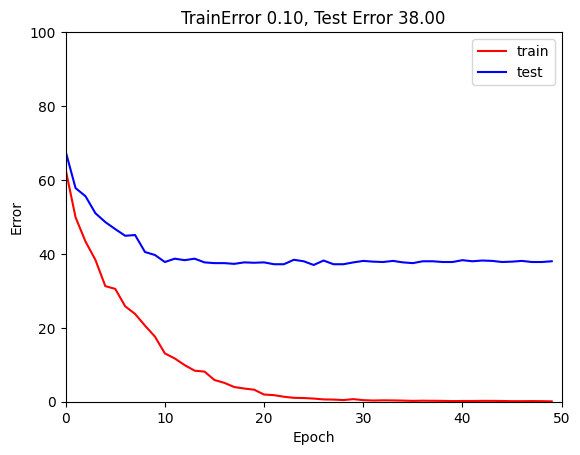

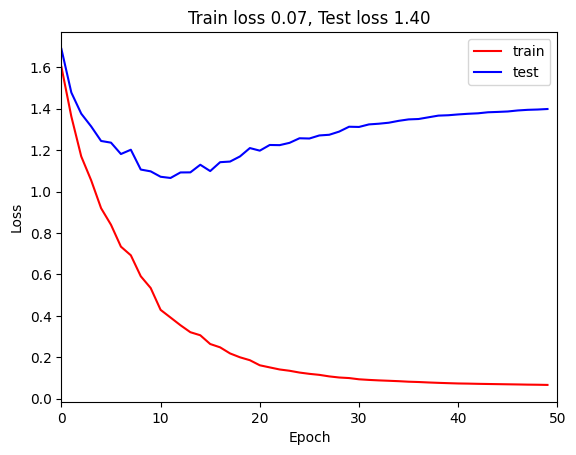

In [6]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show() #ORIGINAL TRAIN/TEST -> ERROR .10, 38.00 -> LOSS .07, 1.40

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

Epoch     0, train loss 2.321232, train error 90.15,  test loss 2.316657, test error 89.40
Epoch     1, train loss 2.332567, train error 90.10,  test loss 2.334338, test error 89.60
Epoch     2, train loss 2.319849, train error 90.15,  test loss 2.314579, test error 89.40
Epoch     3, train loss 2.326476, train error 90.15,  test loss 2.322432, test error 89.40
Epoch     4, train loss 2.249018, train error 87.10,  test loss 2.247789, test error 86.10
Epoch     5, train loss 2.319048, train error 90.07,  test loss 2.317884, test error 89.60
Epoch     6, train loss 2.342415, train error 90.12,  test loss 2.338505, test error 89.40
Epoch     7, train loss 2.326811, train error 90.03,  test loss 2.321753, test error 89.80
Epoch     8, train loss 2.330545, train error 90.03,  test loss 2.331508, test error 89.80
Epoch     9, train loss 2.310948, train error 89.93,  test loss 2.317347, test error 90.20
Epoch    10, train loss 2.313094, train error 90.12,  test loss 2.314293, test error 89.40

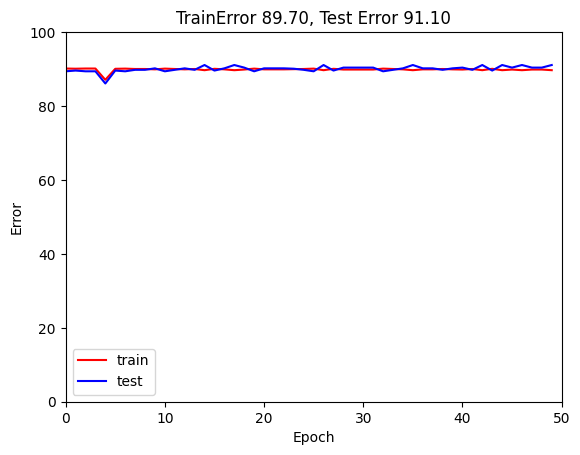

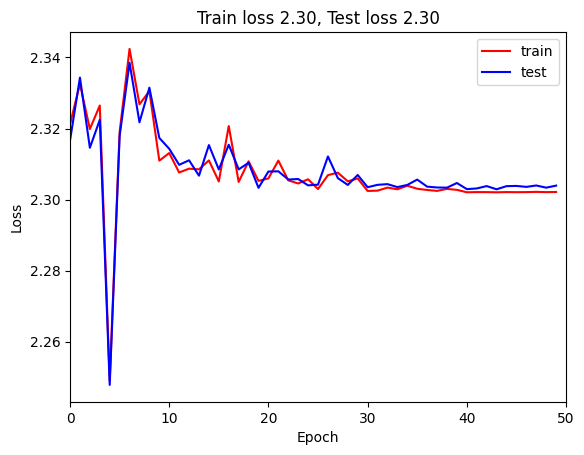

In [10]:
#old param labels
lr = 0.05         #learning rate
batch_size = 100  #batch size
momentum = 0.9    #momentum

D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

#new param labels
lr = 0.9         #learning rate INCREASING LEARNING RATE BRINGS TRAIN AND TEST CLOSER TO EACH OTHER
batch_size = 100  #batch size
momentum = 0.9    #momentum

D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100

# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
#model = torch.nn.Sequential(torch.nn.Linear(D_i, D_o));
model = torch.nn.Sequential(torch.nn.Linear(D_i, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_o));


def weights_init(layer_in):
  # TO DO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  #print("Initializing layer")
  #if type(layer_in) == nn.Linear:
    #nn.init.kaiming_normal_(layer_in.weight)

  #if type(layer_in) == nn.Linear:
   # nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')

  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Call the function you just defined
model.apply(weights_init)

###
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr, momentum)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

###
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

Epoch     0, train loss 1.824430, train error 73.05,  test loss 1.854346, test error 75.30
Epoch     1, train loss 1.579004, train error 61.58,  test loss 1.652844, test error 65.00
Epoch     2, train loss 1.437966, train error 56.03,  test loss 1.553969, test error 63.00
Epoch     3, train loss 1.317101, train error 51.15,  test loss 1.473160, test error 59.50
Epoch     4, train loss 1.196170, train error 44.42,  test loss 1.384602, test error 54.90
Epoch     5, train loss 1.090809, train error 39.90,  test loss 1.310987, test error 51.50
Epoch     6, train loss 1.001378, train error 34.75,  test loss 1.252284, test error 48.80
Epoch     7, train loss 0.929887, train error 32.20,  test loss 1.214441, test error 48.00
Epoch     8, train loss 0.855916, train error 29.40,  test loss 1.171836, test error 43.20
Epoch     9, train loss 0.804741, train error 27.78,  test loss 1.156079, test error 45.40
Epoch    10, train loss 0.747823, train error 24.47,  test loss 1.135789, test error 44.90

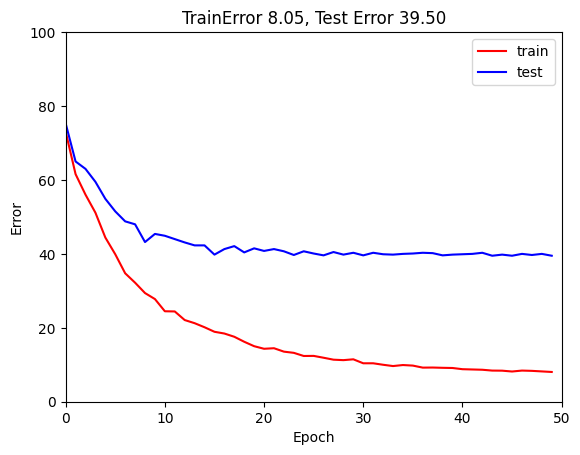

ORIGINAL TRAIN/TEST LOSS .07, 1.40


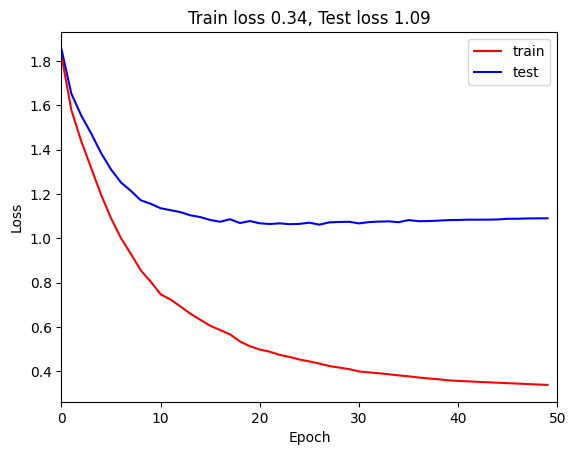

In [14]:
#old param labels
lr = 0.05         #learning rate
batch_size = 100  #batch size
momentum = 0.9    #momentum

D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

#new param labels
lr = 0.05         #learning rate
batch_size = 200  #batch size DOUBLING BATCH SIZE MAKES THINGS WORSE
momentum = 0.9    #momentum

D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100

# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
#model = torch.nn.Sequential(torch.nn.Linear(D_i, D_o));
model = torch.nn.Sequential(torch.nn.Linear(D_i, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_o));


def weights_init(layer_in):
  # TO DO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  #print("Initializing layer")
  #if type(layer_in) == nn.Linear:
    #nn.init.kaiming_normal_(layer_in.weight)

  #if type(layer_in) == nn.Linear:
   # nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')

  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Call the function you just defined
model.apply(weights_init)

###
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr, momentum)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

print("ORIGINAL TRAIN/TEST ERROR .10, 38.00")
###
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

print("ORIGINAL TRAIN/TEST LOSS .07, 1.40")
# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()



Epoch     0, train loss 1.863876, train error 72.05,  test loss 1.903884, test error 73.30
Epoch     1, train loss 1.719724, train error 65.88,  test loss 1.785114, test error 71.00
Epoch     2, train loss 1.644238, train error 63.67,  test loss 1.726702, test error 69.30
Epoch     3, train loss 1.588483, train error 59.53,  test loss 1.687940, test error 66.40
Epoch     4, train loss 1.530285, train error 55.83,  test loss 1.646431, test error 66.10
Epoch     5, train loss 1.489783, train error 54.90,  test loss 1.617012, test error 64.20
Epoch     6, train loss 1.446575, train error 52.12,  test loss 1.580183, test error 61.30
Epoch     7, train loss 1.400288, train error 49.83,  test loss 1.544445, test error 60.60
Epoch     8, train loss 1.365782, train error 48.40,  test loss 1.508031, test error 57.80
Epoch     9, train loss 1.323211, train error 45.83,  test loss 1.481507, test error 57.00
Epoch    10, train loss 1.302976, train error 44.72,  test loss 1.466986, test error 56.30

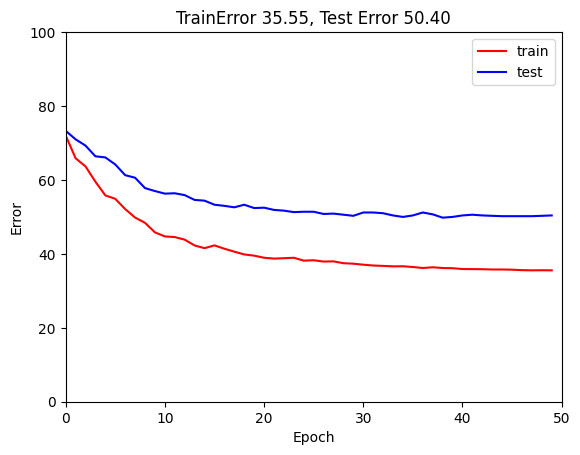

ORIGINAL TRAIN/TEST LOSS .07, 1.40


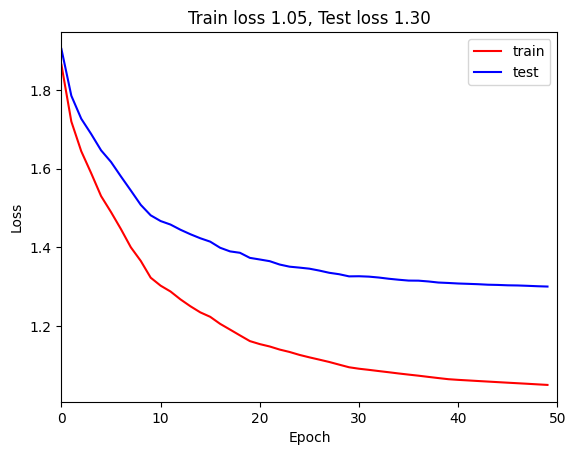

In [16]:
#old param labels
lr = 0.05         #learning rate
batch_size = 100  #batch size
momentum = 0.9    #momentum

D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

#new param labels
lr = 0.05         #learning rate
batch_size = 100  #batch size
momentum = 0.1    #momentum LOWERING MOMENTUM SEEMS TO MAKE EVERYTHING WORSE EXCEPT THE TEST LOSS

D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100

# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
#model = torch.nn.Sequential(torch.nn.Linear(D_i, D_o));
model = torch.nn.Sequential(torch.nn.Linear(D_i, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_o));


def weights_init(layer_in):
  # TO DO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  #print("Initializing layer")
  #if type(layer_in) == nn.Linear:
    #nn.init.kaiming_normal_(layer_in.weight)

  #if type(layer_in) == nn.Linear:
   # nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')

  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Call the function you just defined
model.apply(weights_init)

###
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr, momentum)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

print("ORIGINAL TRAIN/TEST ERROR .10, 38.00")
###
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

print("ORIGINAL TRAIN/TEST LOSS .07, 1.40")
# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()



Epoch     0, train loss 1.490927, train error 55.20,  test loss 1.625555, test error 63.70
Epoch     1, train loss 1.235291, train error 44.97,  test loss 1.463426, test error 58.00
Epoch     2, train loss 0.874178, train error 30.05,  test loss 1.176936, test error 44.80
Epoch     3, train loss 0.643699, train error 20.85,  test loss 1.140666, test error 41.90
Epoch     4, train loss 0.511050, train error 15.95,  test loss 1.127027, test error 42.30
Epoch     5, train loss 0.368352, train error 11.40,  test loss 1.062970, test error 37.60
Epoch     6, train loss 0.261636, train error 6.97,  test loss 1.081926, test error 38.80
Epoch     7, train loss 0.192289, train error 5.30,  test loss 1.113513, test error 35.50
Epoch     8, train loss 0.111006, train error 1.55,  test loss 1.134809, test error 36.40
Epoch     9, train loss 0.079136, train error 1.43,  test loss 1.141509, test error 34.80
Epoch    10, train loss 0.037555, train error 0.03,  test loss 1.086792, test error 33.60
Epoc

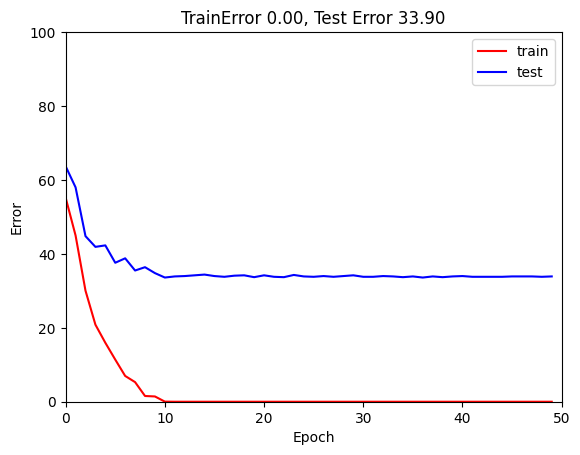

ORIGINAL TRAIN/TEST LOSS .07, 1.40


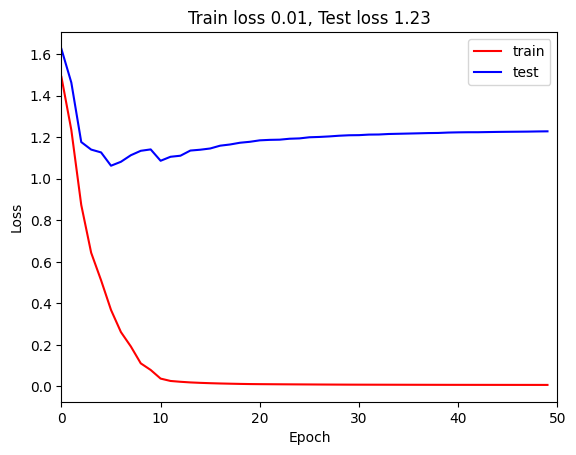

In [24]:
#old param labels
lr = 0.05         #learning rate
batch_size = 100  #batch size
momentum = 0.9    #momentum

D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

#new param labels
lr = 0.05         #learning rate
batch_size = 100  #batch size
momentum = 0.9    #momentum

D_i = 40    # Input dimensions CAN'T CHANGE THIS WITHOUT CREATING ERROR
D_k = 1000   # Hidden dimensions INCREASING HIDDED LAYERS IMPROVES ERROR/LOSS FOR TEST
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100

# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
#model = torch.nn.Sequential(torch.nn.Linear(D_i, D_o));
model = torch.nn.Sequential(torch.nn.Linear(D_i, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_k), torch.nn.ReLU(), torch.nn.Linear(D_k, D_o));


def weights_init(layer_in):
  # TO DO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  #print("Initializing layer")
  #if type(layer_in) == nn.Linear:
    #nn.init.kaiming_normal_(layer_in.weight)

  #if type(layer_in) == nn.Linear:
   # nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')

  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Call the function you just defined
model.apply(weights_init)

###
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr, momentum)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

print("ORIGINAL TRAIN/TEST ERROR .10, 38.00")
###
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

print("ORIGINAL TRAIN/TEST LOSS .07, 1.40")
# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()



TO DO

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like. See if you can improve the test results.

**I was able to improve the test error and loss by increasing the number of hidden layer, but was unable to create improvements by changing the other parameters as shown above in the comments of the code snippets.**

Is it a good idea to optimize the hyperparameters in this way?

**No, while it can give you some insights, it's prone to bias and can cause overfitting**

Will the final result be a good estimate of the true test performance?

**No because a trial and error based approach will not generalize well to unseen data. Using different methods to determine optimum hyperparameters (like search techniques) combined with cross-validation would be a good approach according to Gemini**